#### Double bottom screener

Double bottom in stock price action generates a signal for investors to potentially go long on given stock, since double bottom suggests that (at least temporary) support zone has been formed.

In this post we will examine relatively straigthforward way how to detect patterns resembling double bottoms in a dataset. We will be using only pandas and numpy library. No machine learning libraries like TensorFlow or PyTorch will be utilized.

Detection process:

* downloading daily data for given time interval for a stock ticker
* creation of polynomial fit of given degree
* detection of local minima of the polynomial fit
* setting threshold to filter out local minima that are far away from the global minima
* final detection of bottoming pattern

By double (or multiple) bottom in this article we will understand a pattern that forms both global and local minimums in given dataset. Testing has shown that when we are screening for all local minima, we get too many signals that are generated by not so pronounced local minima in the fitting polynomial.

This algorithm works rather well when given daily stock data for a year or half a year.

Possible outline of double bottom long strategy:

* making a list of S&P 500 stocks or Dividend Aristocrats for example
* run the script in a for loop every week or every month for yearly time range
* in such case the script should detect yearly double global minima which should signal an entry point
* it is useful to run correlation to a trend in the related index (for example AAPL and SPX index)





In [146]:
#optional installations: 
#!pip install yfinance --upgrade --no-cache-dir
#!pip3 install pandas_datareader

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time

#newest yahoo API 
import yfinance as yahoo_finance

#optional 
#yahoo_finance.pdr_override()

%matplotlib inline

In [147]:
# ___variables___
ticker = 'NGG'
#ticker = 'SNP'    # SINOPEC China Petroleum and Chemical Corp 
#ticker = 'CHA'    # China Telecom
#ticker = 'CHL'    # China Mobile
#ticker = 'NGG'    # National Grid

start_time = datetime.datetime(2017, 10, 1)
#end_time = datetime.datetime(2019, 1, 20)
end_time = datetime.datetime.now().date().isoformat()         # today

In [148]:
# yahoo gives only daily historical data
connected = False
while not connected:
    try:
        ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
        connected = True
        print('connected to yahoo')
    except Exception as e:
        print("type error: " + str(e))
        time.sleep( 5 )
        pass   

# use numerical integer index instead of date    
ticker_df = ticker_df.reset_index()
print(ticker_df.head(5))

connected to yahoo
        Date       High        Low       Open      Close    Volume  Adj Close
0 2017-10-02  63.130001  62.509998  62.660000  62.950001  368100.0  56.196339
1 2017-10-03  62.619999  62.369999  62.450001  62.470001  415100.0  55.767841
2 2017-10-04  62.799999  62.540001  62.619999  62.750000  234800.0  56.017792
3 2017-10-05  62.470001  62.259998  62.380001  62.389999  305600.0  55.696423
4 2017-10-06  62.279999  61.779999  61.860001  62.259998  393900.0  55.580368


We will use 'Low' part of the OHLC (Open, High, Low, Close) dataset since we are looking for bottoming patterns. Using 'Close' or 'Adjusted Close' might not give us nice bottoming data since stocks tend to bounce within given day from support ranges.

#### Polynomial fit
* high degree polynomials tend to oscillate significantly and will not correctly classify the dataset
* polynomials of low degree will not have local minima corresponding to double bottom

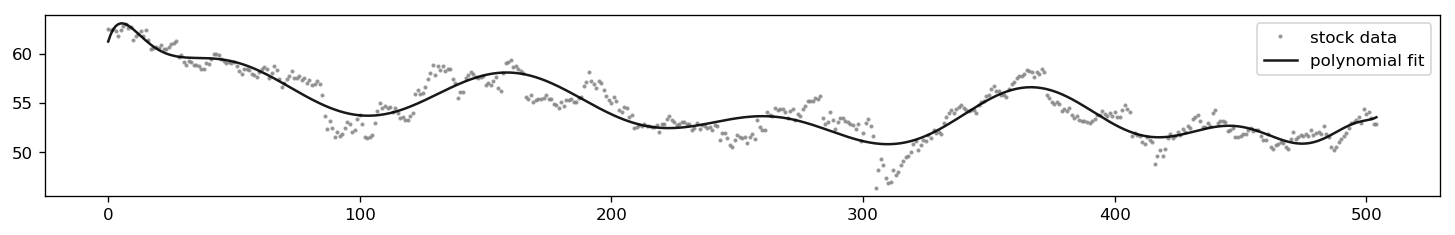

In [149]:
# discrete dataset
x_data = ticker_df.index.tolist()      # the index will be our x axis, not date
y_data = ticker_df['Low']

# x values for the polynomial fit, 200 points
x = np.linspace(0, max(ticker_df.index.tolist()), max(ticker_df.index.tolist()) + 1)

# polynomial fit of degree xx
pol = np.polyfit(x_data, y_data, 17)
y_pol = np.polyval(pol, x)

#           ___ plotting ___
plt.figure(figsize=(15, 2), dpi= 120, facecolor='w', edgecolor='k')

# plot stock data
plt.plot(x_data, y_data, 'o', markersize=1.5, color='grey', alpha=0.7)

# plot polynomial fit
plt.plot(x, y_pol, '-', markersize=1.0, color='black', alpha=0.9)
plt.legend(['stock data', 'polynomial fit'])
plt.show()

#### Detection of local extremes
Local minima are marked in red, local maxima are in blue. We will need only the minimums going forward.

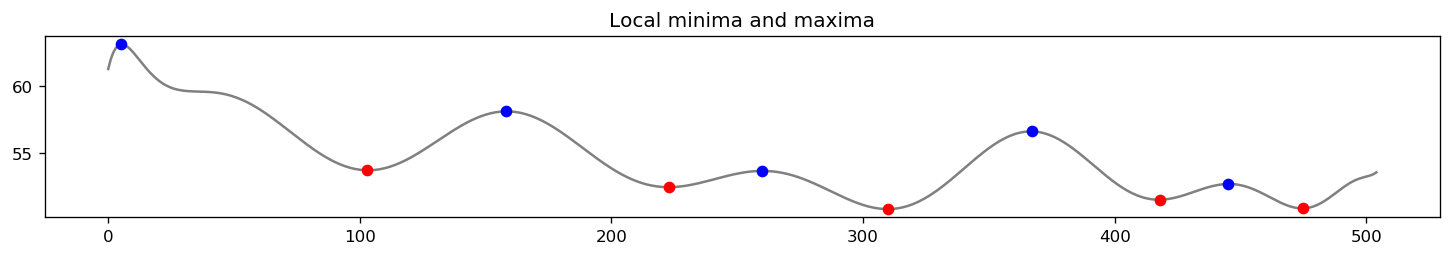

l_min:  [103 223 310 418 475]


In [150]:
data = y_pol

#           ___ detection of local minimums and maximums ___

min_max = np.diff(np.sign(np.diff(data))).nonzero()[0] + 1          # local min & max
l_min = (np.diff(np.sign(np.diff(data))) > 0).nonzero()[0] + 1      # local min
l_max = (np.diff(np.sign(np.diff(data))) < 0).nonzero()[0] + 1      # local max
# +1 due to the fact that diff reduces the original index number

# plot
plt.figure(figsize=(15, 2), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(x, data, color='grey')
plt.plot(x[l_min], data[l_min], "o", label="min", color='r')        # minima
plt.plot(x[l_max], data[l_max], "o", label="max", color='b')        # maxima
plt.title('Local minima and maxima')
plt.show()

print('l_min: ', l_min)

Position of local minima of the fitting function on x axis should correspond to x axis position of the minima in data. Since fitting function is just an approximation, it will be convenient to to use range of days (ticks) around the minimum. And then we would take an average value of the price for that x range to smooth the price values a bit. We will store the data in the dictionary.

In [151]:
#print('corresponding LOW values for suspected indeces: ')
#print(ticker_df.Low.iloc[l_min])

#extend the suspected x range:
delta = 10                                       # how many ticks to the left and to the right from local minimum on x axis

dict_i = dict()
dict_x = dict()

df_len = len(ticker_df.index)                    # number of rows in dataset

for element in l_min:                            # x coordinates of suspected minimums
    l_bound = element - delta                    # lower bound (left)
    u_bound = element + delta                    # upper bound (right)
    x_range = range(l_bound, u_bound + 1)        # range of x positions where we SUSPECT to find a low
    dict_x[element] = x_range                    # just helpful dictionary that holds suspected x ranges for further visualization strips
    
    #print('x_range: ', x_range)
    
    y_loc_list = list()
    for x_element in x_range:
        #print('-----------------')
        if x_element > 0 and x_element < df_len:                # need to stay within the dataframe
            #y_loc_list.append(ticker_df.Low.iloc[x_element])   # list of suspected y values that can be a minimum
            y_loc_list.append(ticker_df.Low.iloc[x_element])
            #print(y_loc_list)
            #print('ticker_df.Low.iloc[x_element]', ticker_df.Low.iloc[x_element])
    dict_i[element] = y_loc_list                 # key in element is suspected x position of minimum
                                                 # to each suspected minimums we append the price values around that x position
                                                 # so 40: [53.70000076293945, 53.93000030517578, 52.84000015258789, 53.290000915527344]
                                                 # x position: [ 40$, 39$, 41$, 45$]
#print('DICTIONARY for l_min: ', dict_i)

Finally when we have x range and y price range identified we can compare the suspected low prices. Also, since we are looking for global minima we set a threshold that is in certain percentage range higher than the lowest datapoint in the dataset. This can be optionally improved by an average of several lowest values to mitigate impact of an outlier value.

#### Double bottom detection

In [152]:
y_delta = 0.12                               # percentage distance between average lows
threshold = min(ticker_df['Low']) * 1.15      # setting threshold higher than the global low

y_dict = dict()
mini = list()
suspected_bottoms = list()
                                              #   BUG somewhere here
for key in dict_i.keys():                     # for suspected minimum x position  
    mn = sum(dict_i[key])/len(dict_i[key])    # this is averaging out the price around that suspected minimum
                                              # if the range of days is too high the average will not make much sense
        
    price_min = min(dict_i[key])    
    mini.append(price_min)                    # lowest value for price around suspected 
    
    l_y = mn * (1.0 - y_delta)                #these values are trying to get an U shape, but it is kinda useless 
    u_y = mn * (1.0 + y_delta)
    y_dict[key] = [l_y, u_y, mn, price_min]
    
#print('y_dict: ') 
#print(y_dict) 

#print('SCREENING FOR DOUBLE BOTTOM:')    
    
for key_i in y_dict.keys():    
    for key_j in y_dict.keys():    
        if (key_i != key_j) and (y_dict[key_i][3] < threshold):
            suspected_bottoms.append(key_i)                          

#### Final visualization

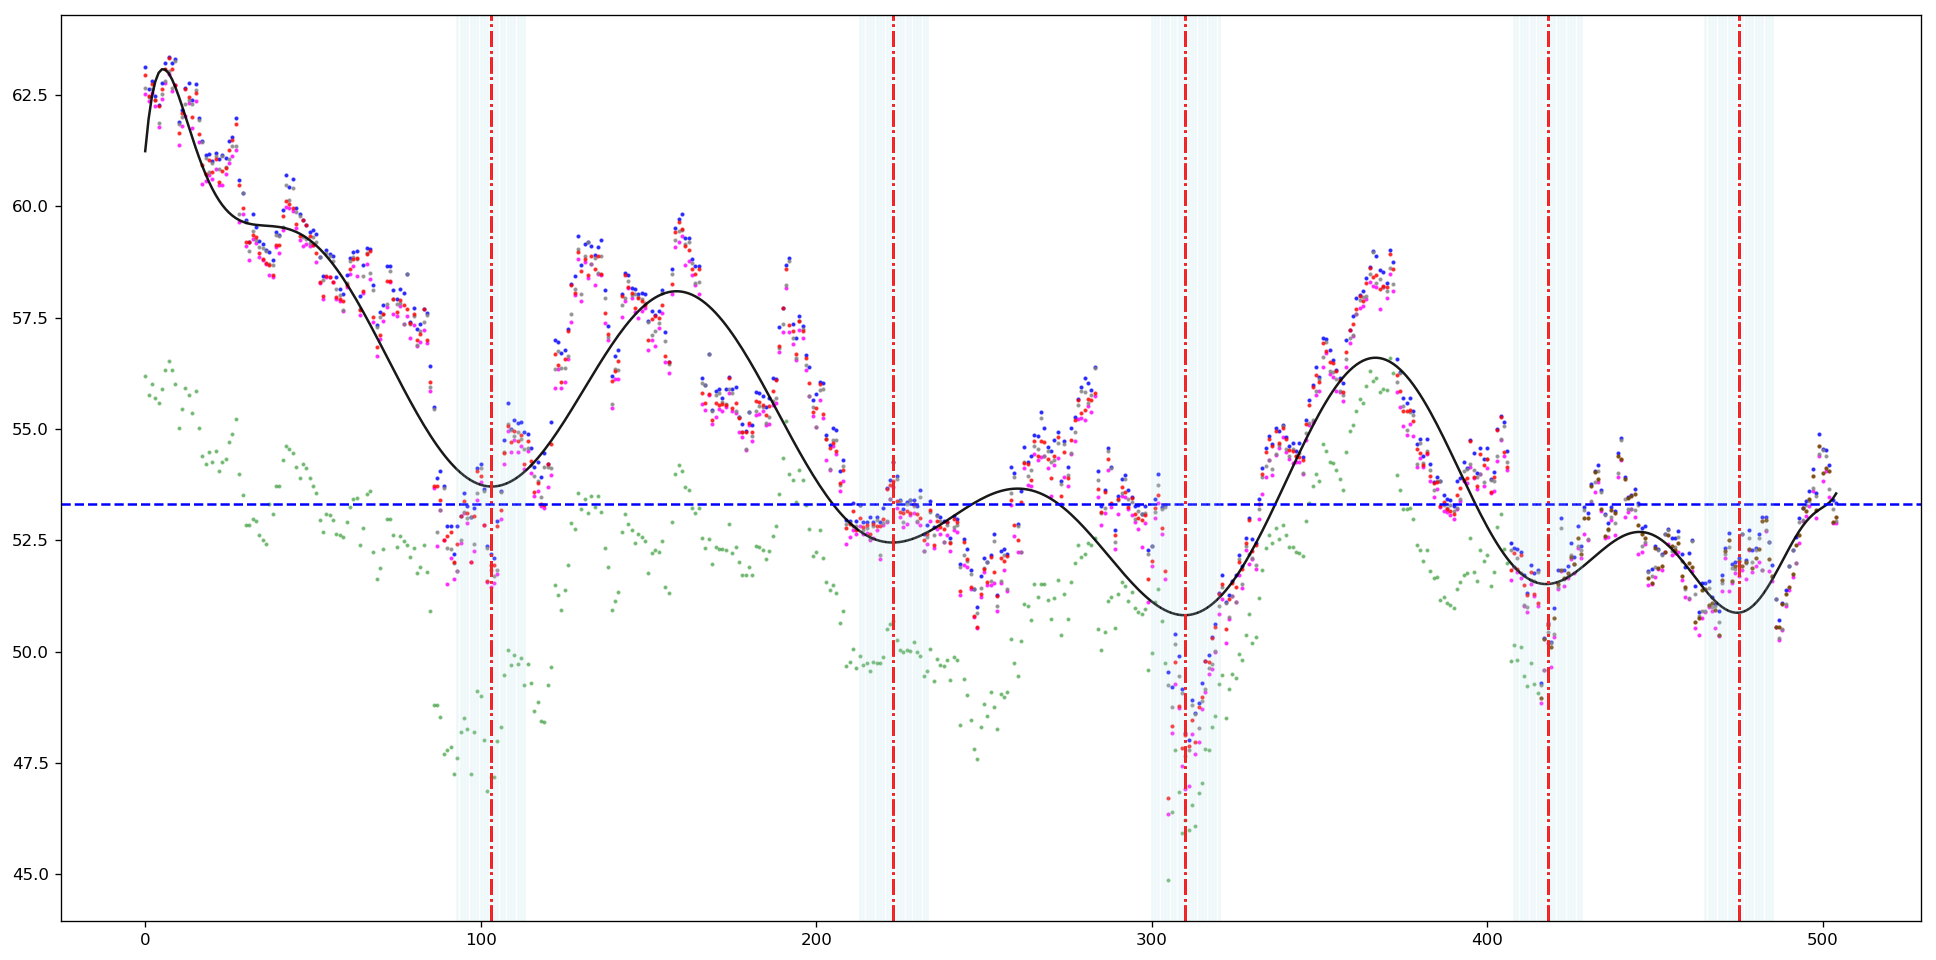

In [153]:
# ___ plotting ___
plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
# plot stock data
plt.plot(x_data, y_data, 'o', markersize=1.5, color='magenta', alpha=0.7)

# we can plot also all the other prices to get a price range for given day just for information
plt.plot(x_data, ticker_df['High'],      'o', markersize=1.5, color='blue',  alpha=0.7)
plt.plot(x_data, ticker_df['Open'],      'o', markersize=1.5, color='grey',  alpha=0.7)
plt.plot(x_data, ticker_df['Close'],     'o', markersize=1.5, color='red', alpha=0.7)    # Adj Close should be more accurate indication (accounts for dividends and stock splits)
plt.plot(x_data, ticker_df['Adj Close'], 'o', markersize=1.5, color='green', alpha=0.4)


# plot polynomial fit
plt.plot(x, y_pol, '-', markersize=1.0, color='black', alpha=0.9)

for position in suspected_bottoms:
    plt.axvline(x=position, linestyle='-.', color='r')
    
plt.axhline(threshold, linestyle='--', color='b')    


for key in dict_x.keys():
    #print('dict key value: ', dict_i[key])
    for value in dict_x[key]:
        plt.axvline(x=value, linestyle='-', color = 'lightblue', alpha=0.2)


plt.show()

# print('dict_x: ', dict_x)   # this dictionary is holding the values of the suspected low price
# print('y_dict:', y_dict)

- vertical red lines:            suspected double(multiple) minimums
- horizontal blue line:          price threshold for detection, we consider ONLY prices below this value
- vertical light blue strips:    areas around local minimums in polynomial fit

- green dots:                    'Adj Close' price, this might be shifted from rest of the price dataset (correction for stock splits and dividends), possibly even better for detecting double bottoms (needs to be tested further). In this notebook we used only 'Low' price.

So double (multiple) bottom is detected only when 'Low' price is below horizontal blue line and inside light blue strip. Position of the blue line threshold and width of the strip are set as constants.

### Summary

Due to nature of polynomial fit of higher degrees, it is better to analyse shorter time frames. 
Also if you have double bottom somewhere in the middle of a dataset, it might get smoothed out by the fit for single local minimum if the the bottoms are close to each other (hence double bottom will not be detected). 
Tests show that the fit works reasonably well at the edge of a dataset. This is exactly what we want during swing trading. Once algorithm detects double minimum, we can buy (have long position). In such case it would not matter much that we have not detected some local double bottom long time ago, it would not be actionable for us anyways.

So in short: this script should be able to detect significant double or multiple bottoms that are far apart from each other.

Note: using 'Adj Close' instead of 'Low' might bring even better results.

#### Sources:
* https://towardsdatascience.com/basic-time-series-analysis-and-trading-strategy-with-bitcoin-price-data-1a8f1a30f11 
* https://www.learndatasci.com/tutorials/python-finance-part-yahoo-finance-api-pandas-matplotlib/ 
* https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py 
* https://stackoverflow.com/questions/4624970/finding-local-maxima-minima-with-numpy-in-a-1d-numpy-array 
* https://www.youtube.com/watch?v=970im6yAmhE